In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/processed_data/merged_characteristics.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']
missing_cols = ['DP05_0028PE', 'Number of Consumers with CSR AV of 87%', 
                'Average Monthly Advanced CSR Payment for Consumers with 87%', 
                'DP05_0018PE', 'Number of Consumers with CSR (AV of 73%/87%/94%)', 'Total Number of Consumers',
                'Number of Consumers with CSR AV of 73%', 'Number of Consumers with CSR AV of 94%', 'FIPS County Code',
                'Average Monthly Advanced CSR Payment for Consumers with 73%', 
                'Average Monthly Advanced CSR Payment for Consumers with 94%', 
                'DP05_0032PE', 'DP05_0004PE', 'County Name']



#setup y
y_cols = ['Ever Enrolled Count']


    
x_cols = []
for col in df.columns:
    if col not in y_cols and col not in keys and col not in missing_cols: 
        x_cols.append(col)  

        
y = df[y_cols]
X = df[x_cols]

X = X/X.std()

In [3]:
training_test = []
num_trials = 10
for i in range(num_trials):
    test_size = 0.33
    np.random.seed()
    X_train, X_test, y_train, y_test = train_test_split(sm.add_constant(X), y, test_size=test_size)
    training_test.append( (X_train, X_test, y_train, y_test) )

/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [4]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,y_test):
    #setup the data
    
    plt.hist(y_pred[y_pred < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()
    
    
def plot_importance(X_test,model):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()

    
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(50)
    #plt.title('20 worst predictions')
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

mse normalized trial  0 : 0.8788858255950344
mse normalized trial  1 : 0.684103247107825
mse normalized trial  2 : 1.0503023882797278
mse normalized trial  3 : 1.5467760337739873
mse normalized trial  4 : 0.6929892356249883
mse normalized trial  5 : 0.7374675267989789
mse normalized trial  6 : 0.8825329210184638
mse normalized trial  7 : 0.7909792752470306
mse normalized trial  8 : 1.3846386441253973
mse normalized trial  9 : 0.7703110524113213


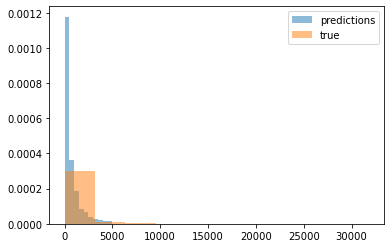

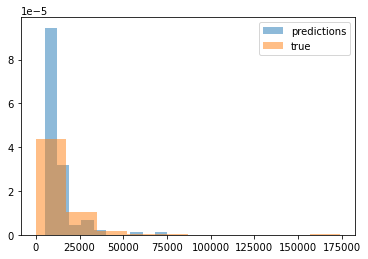

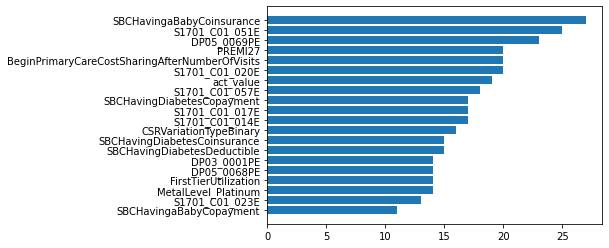

mse 36181070.028588384 r2 0.05810138500172455
mse med 32622289.066557672 r2 med 0.16506744957896752
mse normalized trial  0 : 0.7695837470029389
mse normalized trial  1 : 0.7772727358905623
mse normalized trial  2 : 1.1752059953298344
mse normalized trial  3 : 1.3333274691984769
mse normalized trial  4 : 0.817931416670241
mse normalized trial  5 : 0.7528469591474573
mse normalized trial  6 : 1.1823991993995
mse normalized trial  7 : 0.7993585184368311
mse normalized trial  8 : 1.2605715110052562
mse normalized trial  9 : 0.761013811260883


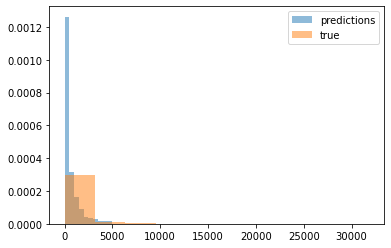

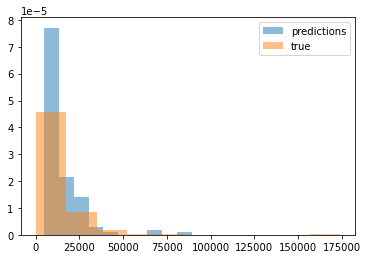

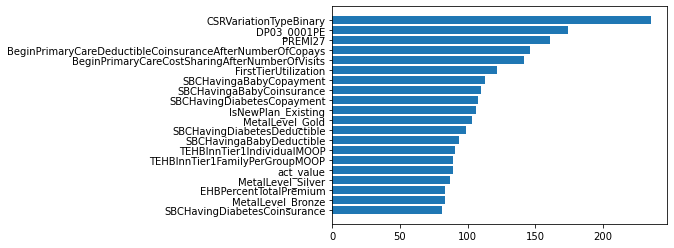

mse 37226775.785038784 r2 0.03704886366580189
mse med 36038869.54936014 r2 med 0.1913550324464639


In [5]:
params = [(2,.5,.9,.9),(5,.5, 0.5, .9)]


for param in params:
    mses = []
    r2s = []
    for i in range(num_trials):
        X_train, X_test, y_train, y_test = training_test[i]
        # not super deep, but uses most of the data at one
        model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=param[0],
                             eta=param[1], subsample=param[2], colsample_bytree=param[3])
        model.fit(X_train, y_train)

        y_pred = get_predictions(model,X_test)
        mse = float( ((y_test - y_pred)**2).mean() )
        r2 = float(  1- mse/y_test.var() ) 
        print('mse normalized trial ', i,':', float(mse/y_test.var()))
        mses.append(mse)
        r2s.append(r2)

        #plot the difference between true and predicted
        if i == num_trials -1:
            split = 5000
            plot_prediction(split,y_pred,y_test)
            plot_importance(X_test,model)

    print( 'mse', np.array(mses).mean() ,'r2', np.array(r2s).mean()  )
    print( 'mse med', np.median(mses) ,'r2 med', np.median(r2s)  )

0.7659913980509325
0.7087619949987329
1.02299316076261
0.5643771067542382
0.8086106919126882
0.8012826604098305
0.6773207347826304
0.8339602193590652
0.9161775454567415
0.7613976194498785


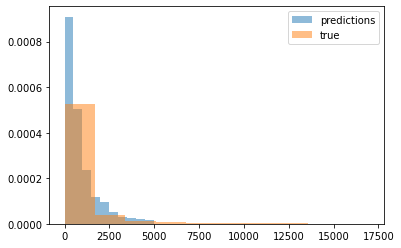

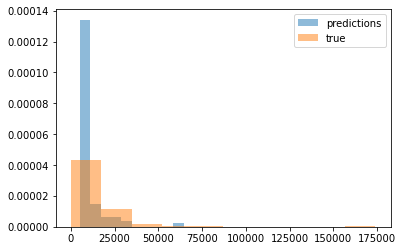

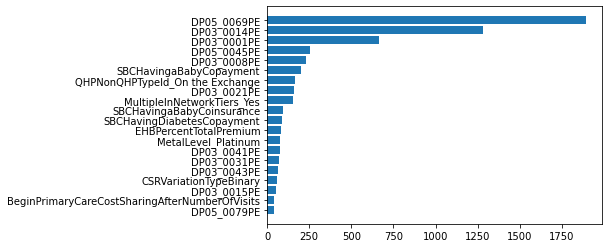

mse trial 9 :                pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
AZ     23499.748903          6952.500000    279.533620   4910.856595
FL     20000.024224         36157.692308  20020.528976  44850.416909
IL     19982.829960         20085.000000  14083.440447  23064.759418
TX     17233.688438         21835.333333   9704.333334  23397.620899
MI      8372.290385          9768.500000   1970.199719  13587.056800
OK      6357.827620         34670.000000           NaN           NaN
GA      6308.324364         20325.800000    967.796047   3649.178360
VA      6055.900974         22863.500000   3830.785910  13555.944102
TN      6030.344670         24894.000000           NaN           NaN
PA      5910.129556         24931.250000    923.850571   7715.864885
UT      5795.854142         26603.666667   3708.923655  11369.465262
OR      5691.438272         23895.000000           NaN           NaN
NE      3909.883237 

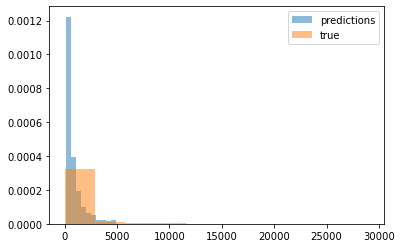

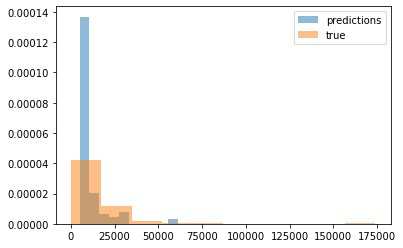

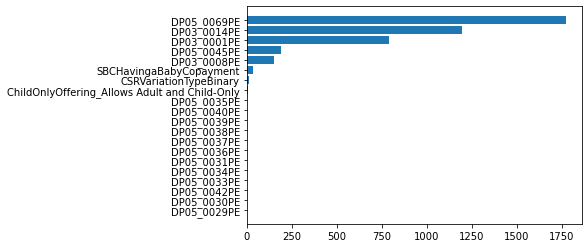

mse trial 9 :                pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
AZ     22797.868639          6952.500000      7.082325   4910.856595
IL     20072.295223         20085.000000  14569.454949  23064.759418
FL     18853.081386         36157.692308  19108.926956  44850.416909
TX     13827.325631         21519.111111   8912.650748  23464.444024
MI      8160.196185          9768.500000   2173.608746  13587.056800
GA      5922.958453         20325.800000    815.809446   3649.178360
TN      5908.045056         24894.000000           NaN           NaN
OR      5783.634109         23895.000000           NaN           NaN
VA      5650.284441         22863.500000   3999.404211  13555.944102
OK      5457.333025         34670.000000           NaN           NaN
UT      5175.263862         26603.666667   3441.125827  11369.465262
LA      4845.849609         15019.000000           NaN           NaN
PA      4551.192437 

In [6]:
# Vary alpha values
a = [100,250]

for i in a: 
    mses = []
    r2s = []
    for j in range(num_trials):
        X_train, X_test, y_train, y_test = training_test[j]
        
        lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
        y_pred = get_predictions(lasso,X_test)

        mse = float(((y_test - y_pred)**2).mean())
        r2 = float( 1 - mse/y_test.var() )
        print(float(mse/y_test.var()))
        mses.append(mse)
        r2s.append(r2)
        

        if j == num_trials -1:
            #plot the difference between true and predicted
            split = 5000
            plot_prediction(split,y_pred,y_test)

            #also plot important feature
            param_df = pd.DataFrame(np.abs(lasso.params),columns=['score']).sort_values(by=['score'], ascending=False).head(20)
            param_df['features'] = param_df.index
            plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
            plt.show()
            print('mse trial', j, ':',report_error(y_test,y_pred))

    print('alpha_value:', i)
    print( 'mse', np.array(mses).mean() ,'r2', np.array(r2s).mean()  )
    print( 'mse med', np.median(mses) ,'r2 med', np.median(r2s)  )
    print('==========================================')
    print('==========================================')

In [7]:
#some training sets total number of consumers?
#some times DP03_CSR?